In [52]:
import pandas as pd
import os

from sklearn.model_selection import train_test_split

import xgboost as xgb
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ndcg_score

import pickle

### Data Preprocessing

In [43]:
# Load the dataset
file_path = os.path.join(os.getcwd(), 'training_data', 'bubble_tea_recommendation_data.csv')

df_raw = pd.read_csv(file_path)

# Display the first few rows of the dataset
print(df_raw.head())


   user_id  drink_id  fruity_user  milky_user  with_tea_user  refreshing_user  \
0        1     101.0            0           0              0                0   
1        1     102.0            0           0              0                0   
2        1     103.0            0           0              0                0   
3        1     104.0            0           0              0                0   
4        1     105.0            0           0              0                0   

   fragrant_user  adventurous_user  cold_user  fruity_drink  milky_drink  \
0              0                 1          0           1.0          0.0   
1              0                 1          0           0.0          1.0   
2              0                 1          0           0.0          1.0   
3              0                 1          0           0.0          0.0   
4              0                 1          0           0.0          0.0   

   with_tea_drink  refreshing_drink  fragrant_drink  col

#### Train-test split

In [44]:
# df = df_raw.drop(columns=['user_id', 'drink_id'])
df = df_raw

In [45]:
from sklearn.model_selection import GroupShuffleSplit

# Define features and target
X = df.drop(columns=['label'])
y = df['label']
groups = df['user_id']

# Split the data into training and validation sets using GroupShuffleSplit
splitter = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_idx, val_idx = next(splitter.split(X, y, groups))

X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
group_train = groups.iloc[train_idx].value_counts().sort_index().values
group_val = groups.iloc[val_idx].value_counts().sort_index().values

print("Train groups:", group_train)
print("Validation groups:", group_val)


Train groups: [50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50
 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50
 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50
 50 50 50 50 50 50 50 50]
Validation groups: [50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50 50]


### Hyperparameter Tuning

In [46]:
# Define the hyperparameter space
space = {
    'max_depth': hp.choice('max_depth', range(3, 15)),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),
    'n_estimators': hp.choice('n_estimators', range(50, 500)),
    'subsample': hp.uniform('subsample', 0.5, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1),
    'gamma': hp.uniform('gamma', 0, 5),
    'reg_alpha': hp.uniform('reg_alpha', 0, 5),
    'reg_lambda': hp.uniform('reg_lambda', 0, 5)
}

In [ ]:
def objective(params):
    model = xgb.XGBRanker(
        max_depth=params['max_depth'],
        learning_rate=params['learning_rate'],
        n_estimators=params['n_estimators'],
        subsample=params['subsample'],
        colsample_bytree=params['colsample_bytree'],
        gamma=params['gamma'],
        reg_alpha=params['reg_alpha'],
        reg_lambda=params['reg_lambda'],
        objective='rank:ndcg',
        eval_metric='ndcg',
        use_label_encoder=False
    )
    model.fit(X_train, y_train, group_train, eval_set=[(X_val, y_val)], eval_group=[group_val], early_stopping_rounds=50, verbose=False)
    score = model.best_score
    return {'loss': -score, 'status': STATUS_OK}

# Run the optimization
trials = Trials()
best_params = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials
)


In [49]:
print("Best parameters:", best_params)

Best parameters: {'colsample_bytree': 0.9555736855489863, 'gamma': 0.030075171203997293, 'learning_rate': 0.11327707888480412, 'max_depth': 10, 'n_estimators': 83, 'reg_alpha': 0.9715479808241062, 'reg_lambda': 4.825104827797944, 'subsample': 0.6798911326386349}


In [50]:
# Update the best_params for correct indices
# best_params['max_depth'] = range(3, 15)[best_params['max_depth']]
# best_params['n_estimators'] = range(50, 500)[best_params['n_estimators']]

best_model = xgb.XGBRanker(
    max_depth=best_params['max_depth'],
    learning_rate=best_params['learning_rate'],
    n_estimators=best_params['n_estimators'],
    subsample=best_params['subsample'],
    colsample_bytree=best_params['colsample_bytree'],
    gamma=best_params['gamma'],
    reg_alpha=best_params['reg_alpha'],
    reg_lambda=best_params['reg_lambda'],
    objective='rank:ndcg',
    eval_metric='ndcg',
    use_label_encoder=False
)

best_model.fit(X, y, group)


c:\Users\User\anaconda3\envs\bobafy\Lib\site-packages\xgboost\core.py:727: FutureWarning: Pass `group` as keyword args.
  warnings.warn(msg, FutureWarning)


XGBRanker(base_score=None, booster=None, callbacks=None, colsample_bylevel=None,
          colsample_bynode=None, colsample_bytree=0.9555736855489863,
          device=None, early_stopping_rounds=None, enable_categorical=False,
          eval_metric='ndcg', feature_types=None, gamma=0.030075171203997293,
          grow_policy=None, importance_type=None, interaction_constraints=None,
          learning_rate=0.11327707888480412, max_bin=None,
          max_cat_threshold=None, max_cat_to_onehot=None, max_delta_step=None,
          max_depth=10, max_leaves=None, min_child_weight=None, missing=nan,
          monotone_constraints=None, multi_strategy=None, n_estimators=83,
          n_jobs=None, num_parallel_tree=None, random_state=None, ...)

### Evaluation

NDCG Score: 0.9948608619584067


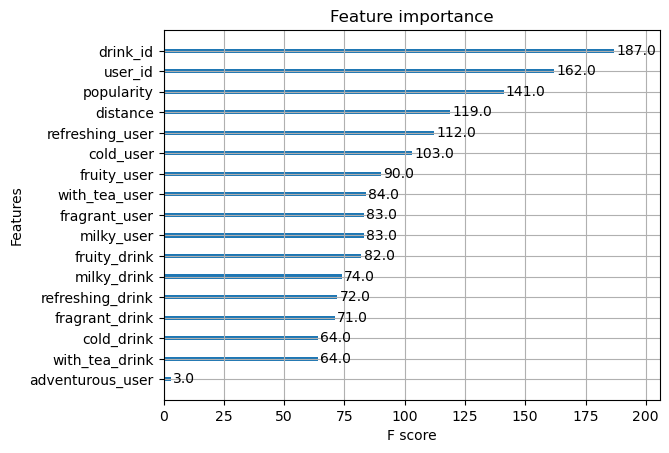

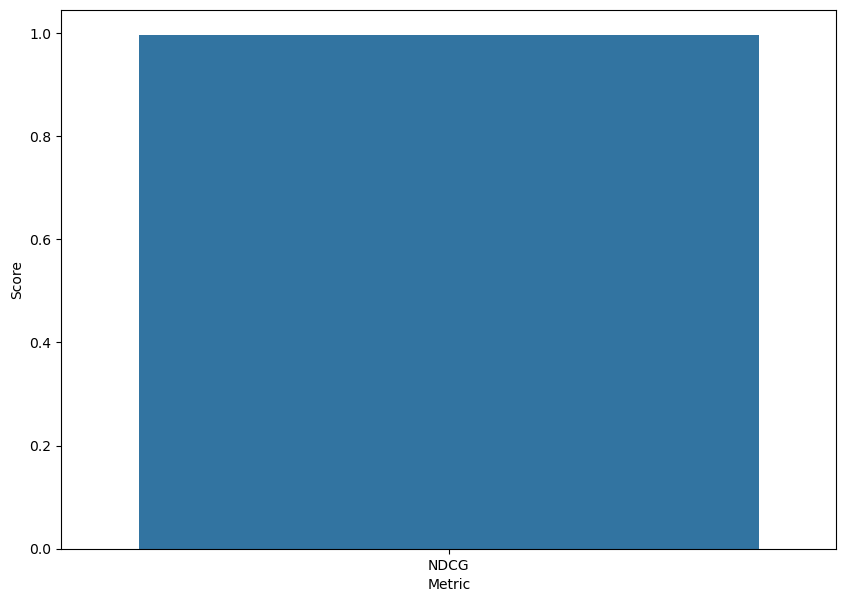

In [51]:
os.makedirs('results', exist_ok=True)

# Plot feature importance
xgb.plot_importance(best_model)
plt.savefig('results/feature_importance.png')

# Evaluate model performance using NDCG
y_pred = best_model.predict(X_val)
ndcg = ndcg_score([y_val], [y_pred])
print(f'NDCG Score: {ndcg}')

# Plot NDCG score
plt.figure(figsize=(10, 7))
sns.barplot(x=['NDCG'], y=[ndcg])
plt.xlabel('Metric')
plt.ylabel('Score')
plt.savefig('results/ndcg_score.png')

# Save evaluation results
results = {
    'ndcg_score': ndcg
}
df_results = pd.DataFrame([results])
df_results.to_csv('results/evaluation_results.csv', index=False)


In [55]:
os.makedirs('output', exist_ok=True)

with open('output/xgboost_model.pkl', 'wb') as file:
    pickle.dump(best_model, file)